# MLP Normalization: влияние нормализации на обучение глубоких MLP

Цель: изучить влияние различных типов нормализации на обучение глубоких MLP сетей.

Данные: Wine Quality (мультиклассовая классификация) - переиспользуем препроцессинг из предыдущего семинара.

Структура:
1. Абстрактные базовые классы для MLP блока и DeepMLP
2. Plain MLP блок без нормализации - базовый случай
3. Эксперименты с разными глубинами и ширинами для plain модели
4. Добавление нормализации (BatchNorm, LayerNorm, GroupNorm)
5. Эксперименты с нормализацией для разных глубин и ширины

Метрики: Accuracy и F1 (macro); кривые train/val loss


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchmetrics.classification import (
    Accuracy, F1Score
)
import sys
sys.path.append('../../lesson3/seminar')
from wine_quality_data import WineQualityDataModule
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer

sns.set_style("whitegrid")
set_seed(42)


## 1. Абстрактные базовые классы

Создаем абстрактные базовые классы для MLP блока и глубокой MLP сети, от которых будут наследоваться конкретные реализации.


In [2]:
from abc import ABC, abstractmethod

class BaseMLPBlock(nn.Module, ABC):
    """
    Абстрактный базовый класс для MLP блока.
    
    Args:
        dim: размерность входа
        hidden_dim: размерность скрытого слоя и выхода (если None, то равен dim)
        activation: функция активации ('relu', 'gelu', 'swish')
        dropout: вероятность dropout
    """
    def __init__(
        self,
        dim,
        hidden_dim=None,
        activation='relu',
        dropout=0.0
    ):
        super().__init__()
        
        self.dim = dim
        self.hidden_dim = hidden_dim if hidden_dim is not None else dim
        
        # Линейные слои: dim -> hidden_dim -> hidden_dim
        self.linear1 = nn.Linear(self.dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        
        # Активация
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        elif activation == 'swish':
            self.activation = nn.SiLU()
        else:
            self.activation = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None
    
    @abstractmethod
    def forward(self, x):
        """
        Forward pass через блок.
        Выход всегда имеет размерность hidden_dim.
        """
        pass


class BaseDeepMLP(nn.Module, ABC):
    """
    Абстрактный базовый класс для глубокой MLP сети.
    
    Args:
        input_dim: размерность входа
        output_dim: размерность выхода
        hidden_dim: размерность скрытых слоев
        num_blocks: количество блоков
        block_kwargs: дополнительные аргументы для блока
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_blocks = num_blocks
        
        # Входной проекционный слой
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        
        # Блоки (будут созданы в дочерних классах)
        self.blocks = None
        
        # Выходной слой
        self.output_proj = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.input_proj(x)
        
        if self.blocks is not None:
            for block in self.blocks:
                x = block(x)
        
        x = self.output_proj(x)
        return x


## 2. Plain MLP блок без нормализации

Реализуем простой MLP блок без нормализации - базовый случай для сравнения.


In [19]:
class PlainMLPBlock(BaseMLPBlock):
    """
    Простой MLP блок без нормализации.
    """
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x


class PlainDeepMLP(BaseDeepMLP):
    """
    Глубокая MLP сеть из PlainMLPBlock без нормализации.
    """
    def __init__(
        self,
        input_dim,
        output_dim,
        hidden_dim=128,
        num_blocks=4,
        block_kwargs=None
    ):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            PlainMLPBlock(dim=hidden_dim, hidden_dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


# Проверка корректности
print("=== Проверка PlainMLPBlock ===")
batch_size = 32
dim = 64

block = PlainMLPBlock(dim=dim, hidden_dim=dim)
x = torch.randn(batch_size, dim)
out = block(x)
assert out.shape == x.shape, f"Ожидалось {x.shape}, получено {out.shape}"
print(f"✓ Одинаковые размеры: {x.shape} -> {out.shape}")

block2 = PlainMLPBlock(dim=dim, hidden_dim=128)
x2 = torch.randn(batch_size, dim)
out2 = block2(x2)
assert out2.shape == (batch_size, 128), f"Ожидалось {(batch_size, 128)}, получено {out2.shape}"
print(f"✓ Разные размеры: {x2.shape} -> {out2.shape}")

print("✓ PlainMLPBlock работает корректно!")


=== Проверка PlainMLPBlock ===
✓ Одинаковые размеры: torch.Size([32, 64]) -> torch.Size([32, 64])
✓ Разные размеры: torch.Size([32, 64]) -> torch.Size([32, 128])
✓ PlainMLPBlock работает корректно!


## 3. Подготовка данных

Загрузим и подготовим датасет Wine Quality для мультиклассовой классификации.


In [20]:
data_module = WineQualityDataModule(batch_size=64, val_split=0.2, random_state=42)
data_module.prepare_data()
data_module.setup()

print(f"Input dimension: {data_module.input_dim}")
print(f"Number of classes: {data_module.n_classes}")
print(f"Train samples: {len(data_module.train_dataset)}")
print(f"Val samples: {len(data_module.val_dataset)}")


Input dimension: 11
Number of classes: 6
Train samples: 1279
Val samples: 320


## 4. Эксперимент 1: Plain MLP с разными глубинами и ширинами

Изучим влияние глубины и ширины сети на обучение plain MLP без нормализации.


In [22]:
def train_model(model, name, max_epochs=25):
    """Обучает модель и возвращает историю метрик."""
    set_seed(42)
    
    loss_fn = nn.CrossEntropyLoss()
    
    lightning_module = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type='adam',
        learning_rate=1e-3,
        task_type='multiclass'
    )
    
    trainer = Trainer(
        max_epochs=max_epochs,
        enable_progress_bar=False,
        enable_model_summary=False,
        logger=False
    )
    
    print(f"\n=== Обучение {name} ===")
    trainer.fit(lightning_module, data_module)
    
    # Собираем метрики
    history = {
        'train_loss': lightning_module.train_losses,
        'val_loss': lightning_module.val_losses,
        'name': name
    }
    
    # Вычисляем финальные метрики
    lightning_module.eval()
    model.eval()
    
    y_true_all = []
    y_pred_all = []
    
    with torch.no_grad():
        for batch in data_module.val_dataloader():
            x, y = batch
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            y_true_all.append(y.numpy())
            y_pred_all.append(preds.numpy())
    
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    
    y_true_tensor = torch.LongTensor(y_true)
    y_pred_tensor = torch.LongTensor(y_pred)
    
    accuracy_metric = Accuracy(task='multiclass', num_classes=data_module.n_classes)
    f1_metric = F1Score(task='multiclass', num_classes=data_module.n_classes, average='macro')
    
    accuracy = accuracy_metric(y_pred_tensor, y_true_tensor).item()
    f1 = f1_metric(y_pred_tensor, y_true_tensor).item()
    
    history['final_accuracy'] = accuracy
    history['final_f1'] = f1
    
    print(f"Accuracy: {accuracy:.4f}, F1 (macro): {f1:.4f}")
    
    return history


### 4.1. Эксперимент с разными глубинами

Сравним plain MLP с разным количеством блоков при фиксированной ширине.


In [23]:
# Эксперимент с разными глубинами
depths = [2, 6, 12, 18, 24]
hidden_dim = 128
results_depth = {}

for num_blocks in depths:
    model = PlainDeepMLP(
        input_dim=data_module.input_dim,
        output_dim=data_module.n_classes,
        hidden_dim=hidden_dim,
        num_blocks=num_blocks,
        block_kwargs={'dropout': 0.1}
    )
    
    name = f"Plain (depth={num_blocks}, width={hidden_dim})"
    history = train_model(model, name, max_epochs=25)
    results_depth[name] = history


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Plain (depth=2, width=128) ===
Epoch 0: accuracy=0.1406, f1_macro=0.0493
Epoch 0: accuracy=0.4397, f1_macro=0.2063
Epoch 1: accuracy=0.4870, f1_macro=0.2133
Epoch 2: accuracy=0.5110, f1_macro=0.2158
Epoch 3: accuracy=0.5284, f1_macro=0.2243
Epoch 4: accuracy=0.5457, f1_macro=0.2404
Epoch 5: accuracy=0.5532, f1_macro=0.2416
Epoch 6: accuracy=0.5629, f1_macro=0.2537
Epoch 7: accuracy=0.5696, f1_macro=0.2576
Epoch 8: accuracy=0.5738, f1_macro=0.2623
Epoch 9: accuracy=0.5769, f1_macro=0.2633
Epoch 10: accuracy=0.5759, f1_macro=0.2612
Epoch 11: accuracy=0.5779, f1_macro=0.2627
Epoch 12: accuracy=0.5807, f1_macro=0.2648
Epoch 13: accuracy=0.5836, f1_macro=0.2677
Epoch 14: accuracy=0.5854, f1_macro=0.2697
Epoch 15: accuracy=0.5869, f1_macro=0.2716
Epoch 16: accuracy=0.5889, f1_macro=0.2730
Epoch 17: accuracy=0.5904, f1_macro=0.2741
Epoch 18: accuracy=0.5917, f1_macro=0.2763
Epoch 19: accuracy=0.5930, f1_macro=0.2788
Epoch 20: accuracy=0.5935, f1_macro=0.2799
Epoch 21: accuracy=0

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5982, f1_macro=0.2846


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6125, F1 (macro): 0.3043

=== Обучение Plain (depth=6, width=128) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3750, f1_macro=0.0961
Epoch 3: accuracy=0.4112, f1_macro=0.1293
Epoch 4: accuracy=0.4323, f1_macro=0.1444
Epoch 5: accuracy=0.4517, f1_macro=0.1571
Epoch 6: accuracy=0.4666, f1_macro=0.1647
Epoch 7: accuracy=0.4795, f1_macro=0.1712
Epoch 8: accuracy=0.4904, f1_macro=0.1768
Epoch 9: accuracy=0.4976, f1_macro=0.1797
Epoch 10: accuracy=0.5030, f1_macro=0.1813
Epoch 11: accuracy=0.5098, f1_macro=0.1847
Epoch 12: accuracy=0.5166, f1_macro=0.1872
Epoch 13: accuracy=0.5221, f1_macro=0.1896
Epoch 14: accuracy=0.5256, f1_macro=0.2014
Epoch 15: accuracy=0.5292, f1_macro=0.2027
Epoch 16: accuracy=0.5329, f1_macro=0.2042
Epoch 17: accuracy=0.5384, f1_macro=0.2156
Epoch 18: accuracy=0.5427, f1_macro=0.2248
Epoch 19: accuracy=0.5463, f1_macro=0.2299
Epoch 20: accuracy=0.5494,

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5646, f1_macro=0.2565


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6531, F1 (macro): 0.3328

=== Обучение Plain (depth=12, width=128) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.2857, f1_macro=0.0848
Epoch 1: accuracy=0.3333, f1_macro=0.0897
Epoch 2: accuracy=0.3529, f1_macro=0.0915
Epoch 3: accuracy=0.3693, f1_macro=0.1336
Epoch 4: accuracy=0.3796, f1_macro=0.1437
Epoch 5: accuracy=0.3867, f1_macro=0.1464
Epoch 6: accuracy=0.3919, f1_macro=0.1465
Epoch 7: accuracy=0.3929, f1_macro=0.1474
Epoch 8: accuracy=0.3963, f1_macro=0.1476
Epoch 9: accuracy=0.3990, f1_macro=0.1470
Epoch 10: accuracy=0.3991, f1_macro=0.1482
Epoch 11: accuracy=0.4012, f1_macro=0.1478
Epoch 12: accuracy=0.4030, f1_macro=0.1472
Epoch 13: accuracy=0.4045, f1_macro=0.1463
Epoch 14: accuracy=0.4058, f1_macro=0.1454
Epoch 15: accuracy=0.4143, f1_macro=0.1483
Epoch 16: accuracy=0.4230, f1_macro=0.1516
Epoch 17: accuracy=0.4305, f1_macro=0.1546
Epoch 18: accuracy=0.4367, f1_macro=0.1574
Epoch 19: accuracy=0.4401, f1_macro=0.1594
Epoch 20: accuracy=0.4461

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4662, f1_macro=0.1740


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5688, F1 (macro): 0.2083

=== Обучение Plain (depth=18, width=128) ===
Epoch 0: accuracy=0.0469, f1_macro=0.0179
Epoch 0: accuracy=0.2991, f1_macro=0.0986
Epoch 1: accuracy=0.3411, f1_macro=0.1026
Epoch 2: accuracy=0.3658, f1_macro=0.1496
Epoch 3: accuracy=0.3793, f1_macro=0.1556
Epoch 4: accuracy=0.3877, f1_macro=0.1551
Epoch 5: accuracy=0.3936, f1_macro=0.1529
Epoch 6: accuracy=0.3978, f1_macro=0.1503
Epoch 7: accuracy=0.3981, f1_macro=0.1547
Epoch 8: accuracy=0.4009, f1_macro=0.1529
Epoch 9: accuracy=0.4032, f1_macro=0.1510
Epoch 10: accuracy=0.4030, f1_macro=0.1539
Epoch 11: accuracy=0.4047, f1_macro=0.1525
Epoch 12: accuracy=0.4062, f1_macro=0.1510
Epoch 13: accuracy=0.4076, f1_macro=0.1495
Epoch 14: accuracy=0.4087, f1_macro=0.1481
Epoch 15: accuracy=0.4097, f1_macro=0.1466
Epoch 16: accuracy=0.4091, f1_macro=0.1497
Epoch 17: accuracy=0.4086, f1_macro=0.1517
Epoch 18: accuracy=0.4095, f1_macro=0.1507
Epoch 19: accuracy=0.4102, f1_macro=0.1497
Epoch 20: accuracy=0.4098

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4122, f1_macro=0.1479


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение Plain (depth=24, width=128) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.2857, f1_macro=0.0848
Epoch 1: accuracy=0.3333, f1_macro=0.0897
Epoch 2: accuracy=0.3603, f1_macro=0.1376
Epoch 3: accuracy=0.3750, f1_macro=0.1444
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3958, f1_macro=0.1457
Epoch 8: accuracy=0.3989, f1_macro=0.1443
Epoch 9: accuracy=0.4014, f1_macro=0.1428
Epoch 10: accuracy=0.4013, f1_macro=0.1461
Epoch 11: accuracy=0.4032, f1_macro=0.1450
Epoch 12: accuracy=0.4049, f1_macro=0.1438
Epoch 13: accuracy=0.4062, f1_macro=0.1426
Epoch 14: accuracy=0.4075, f1_macro=0.1414
Epoch 15: accuracy=0.4085, f1_macro=0.1402
Epoch 16: accuracy=0.4080, f1_macro=0.1434
Epoch 17: accuracy=0.4076, f1_macro=0.1457
Epoch 18: accuracy=0.4085, f1_macro=0.1449
Epoch 19: accuracy=0.4093, f1_macro=0.1440
Epoch 20: accuracy=0.4100

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4124, f1_macro=0.1399
Accuracy: 0.4250, F1 (macro): 0.0994


### 4.2. Эксперимент с разными ширинами

Сравним plain MLP с разной шириной при фиксированной глубине.


In [26]:
# Эксперимент с разными ширинами
widths = [64, 128, 256, 512, 1024]
num_blocks = 6
results_width = {}

for hidden_dim in widths:
    model = PlainDeepMLP(
        input_dim=data_module.input_dim,
        output_dim=data_module.n_classes,
        hidden_dim=hidden_dim,
        num_blocks=num_blocks,
        block_kwargs={'dropout': 0.1}
    )
    
    name = f"Plain (depth={num_blocks}, width={hidden_dim})"
    history = train_model(model, name, max_epochs=25)
    results_width[name] = history


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение Plain (depth=6, width=64) ===
Epoch 0: accuracy=0.3672, f1_macro=0.1074
Epoch 0: accuracy=0.4085, f1_macro=0.0967
Epoch 1: accuracy=0.4154, f1_macro=0.0978
Epoch 2: accuracy=0.4182, f1_macro=0.0983
Epoch 3: accuracy=0.4197, f1_macro=0.0985
Epoch 4: accuracy=0.4207, f1_macro=0.0987
Epoch 5: accuracy=0.4214, f1_macro=0.0988
Epoch 6: accuracy=0.4358, f1_macro=0.1181
Epoch 7: accuracy=0.4498, f1_macro=0.1335
Epoch 8: accuracy=0.4618, f1_macro=0.1442
Epoch 9: accuracy=0.4724, f1_macro=0.1517
Epoch 10: accuracy=0.4805, f1_macro=0.1572
Epoch 11: accuracy=0.4877, f1_macro=0.1619
Epoch 12: accuracy=0.4935, f1_macro=0.1659
Epoch 13: accuracy=0.4996, f1_macro=0.1700
Epoch 14: accuracy=0.5034, f1_macro=0.1720
Epoch 15: accuracy=0.5086, f1_macro=0.1751
Epoch 16: accuracy=0.5133, f1_macro=0.1779
Epoch 17: accuracy=0.5178, f1_macro=0.1803
Epoch 18: accuracy=0.5211, f1_macro=0.1824
Epoch 19: accuracy=0.5241, f1_macro=0.1843
Epoch 20: accuracy=0.5264, f1_macro=0.1854
Epoch 21: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5385, f1_macro=0.1995


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6438, F1 (macro): 0.3225

=== Обучение Plain (depth=6, width=128) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0945
Epoch 2: accuracy=0.3750, f1_macro=0.0961
Epoch 3: accuracy=0.4112, f1_macro=0.1293
Epoch 4: accuracy=0.4323, f1_macro=0.1444
Epoch 5: accuracy=0.4517, f1_macro=0.1571
Epoch 6: accuracy=0.4666, f1_macro=0.1647
Epoch 7: accuracy=0.4795, f1_macro=0.1712
Epoch 8: accuracy=0.4904, f1_macro=0.1768
Epoch 9: accuracy=0.4976, f1_macro=0.1797
Epoch 10: accuracy=0.5030, f1_macro=0.1813
Epoch 11: accuracy=0.5098, f1_macro=0.1847
Epoch 12: accuracy=0.5166, f1_macro=0.1872
Epoch 13: accuracy=0.5221, f1_macro=0.1896
Epoch 14: accuracy=0.5256, f1_macro=0.2014
Epoch 15: accuracy=0.5292, f1_macro=0.2027
Epoch 16: accuracy=0.5329, f1_macro=0.2042
Epoch 17: accuracy=0.5384, f1_macro=0.2156
Epoch 18: accuracy=0.5427, f1_macro=0.2248
Epoch 19: accuracy=0.5463, f1_macro=0.2299
Epoch 20: accuracy=0.5494,

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5646, f1_macro=0.2565


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6531, F1 (macro): 0.3328

=== Обучение Plain (depth=6, width=256) ===
Epoch 0: accuracy=0.3672, f1_macro=0.1074
Epoch 0: accuracy=0.4085, f1_macro=0.0967
Epoch 1: accuracy=0.4154, f1_macro=0.0978
Epoch 2: accuracy=0.4494, f1_macro=0.1486
Epoch 3: accuracy=0.4759, f1_macro=0.1643
Epoch 4: accuracy=0.4907, f1_macro=0.1706
Epoch 5: accuracy=0.5039, f1_macro=0.1765
Epoch 6: accuracy=0.5135, f1_macro=0.1805
Epoch 7: accuracy=0.5268, f1_macro=0.2062
Epoch 8: accuracy=0.5293, f1_macro=0.2232
Epoch 9: accuracy=0.5349, f1_macro=0.2230
Epoch 10: accuracy=0.5400, f1_macro=0.2336
Epoch 11: accuracy=0.5436, f1_macro=0.2334
Epoch 12: accuracy=0.5473, f1_macro=0.2330
Epoch 13: accuracy=0.5510, f1_macro=0.2406
Epoch 14: accuracy=0.5515, f1_macro=0.2444
Epoch 15: accuracy=0.5564, f1_macro=0.2498
Epoch 16: accuracy=0.5609, f1_macro=0.2534
Epoch 17: accuracy=0.5650, f1_macro=0.2566
Epoch 18: accuracy=0.5673, f1_macro=0.2608
Epoch 19: accuracy=0.5702, f1_macro=0.2637
Epoch 20: accuracy=0.5717,

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5807, f1_macro=0.2738


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6000, F1 (macro): 0.2971

=== Обучение Plain (depth=6, width=512) ===
Epoch 0: accuracy=0.0156, f1_macro=0.0062
Epoch 0: accuracy=0.3080, f1_macro=0.0951
Epoch 1: accuracy=0.3568, f1_macro=0.0994
Epoch 2: accuracy=0.4118, f1_macro=0.1403
Epoch 3: accuracy=0.4425, f1_macro=0.1606
Epoch 4: accuracy=0.4630, f1_macro=0.1711
Epoch 5: accuracy=0.4829, f1_macro=0.1959
Epoch 6: accuracy=0.4932, f1_macro=0.1975
Epoch 7: accuracy=0.5056, f1_macro=0.2014
Epoch 8: accuracy=0.5160, f1_macro=0.2110
Epoch 9: accuracy=0.5216, f1_macro=0.2111
Epoch 10: accuracy=0.5274, f1_macro=0.2122
Epoch 11: accuracy=0.5338, f1_macro=0.2272
Epoch 12: accuracy=0.5399, f1_macro=0.2373
Epoch 13: accuracy=0.5447, f1_macro=0.2436
Epoch 14: accuracy=0.5461, f1_macro=0.2469
Epoch 15: accuracy=0.5513, f1_macro=0.2535
Epoch 16: accuracy=0.5539, f1_macro=0.2565
Epoch 17: accuracy=0.5557, f1_macro=0.2580
Epoch 18: accuracy=0.5588, f1_macro=0.2630
Epoch 19: accuracy=0.5620, f1_macro=0.2667
Epoch 20: accuracy=0.5635,

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6281, F1 (macro): 0.3078

=== Обучение Plain (depth=6, width=1024) ===
Epoch 0: accuracy=0.4297, f1_macro=0.1202
Epoch 0: accuracy=0.4263, f1_macro=0.1491
Epoch 1: accuracy=0.4258, f1_macro=0.1363
Epoch 2: accuracy=0.4531, f1_macro=0.1535
Epoch 3: accuracy=0.4773, f1_macro=0.1659
Epoch 4: accuracy=0.4925, f1_macro=0.1731
Epoch 5: accuracy=0.5020, f1_macro=0.1785
Epoch 6: accuracy=0.5144, f1_macro=0.1846
Epoch 7: accuracy=0.5238, f1_macro=0.1896
Epoch 8: accuracy=0.5309, f1_macro=0.1992
Epoch 9: accuracy=0.5343, f1_macro=0.1996
Epoch 10: accuracy=0.5373, f1_macro=0.2003
Epoch 11: accuracy=0.5421, f1_macro=0.2089
Epoch 12: accuracy=0.5452, f1_macro=0.2202
Epoch 13: accuracy=0.5501, f1_macro=0.2296
Epoch 14: accuracy=0.5528, f1_macro=0.2350
Epoch 15: accuracy=0.5581, f1_macro=0.2437
Epoch 16: accuracy=0.5621, f1_macro=0.2462
Epoch 17: accuracy=0.5674, f1_macro=0.2494
Epoch 18: accuracy=0.5712, f1_macro=0.2535
Epoch 19: accuracy=0.5740, f1_macro=0.2587
Epoch 20: accuracy=0.5759

`Trainer.fit` stopped: `max_epochs=25` reached.


Accuracy: 0.6000, F1 (macro): 0.2905


### 4.3. Визуализация результатов для Plain MLP


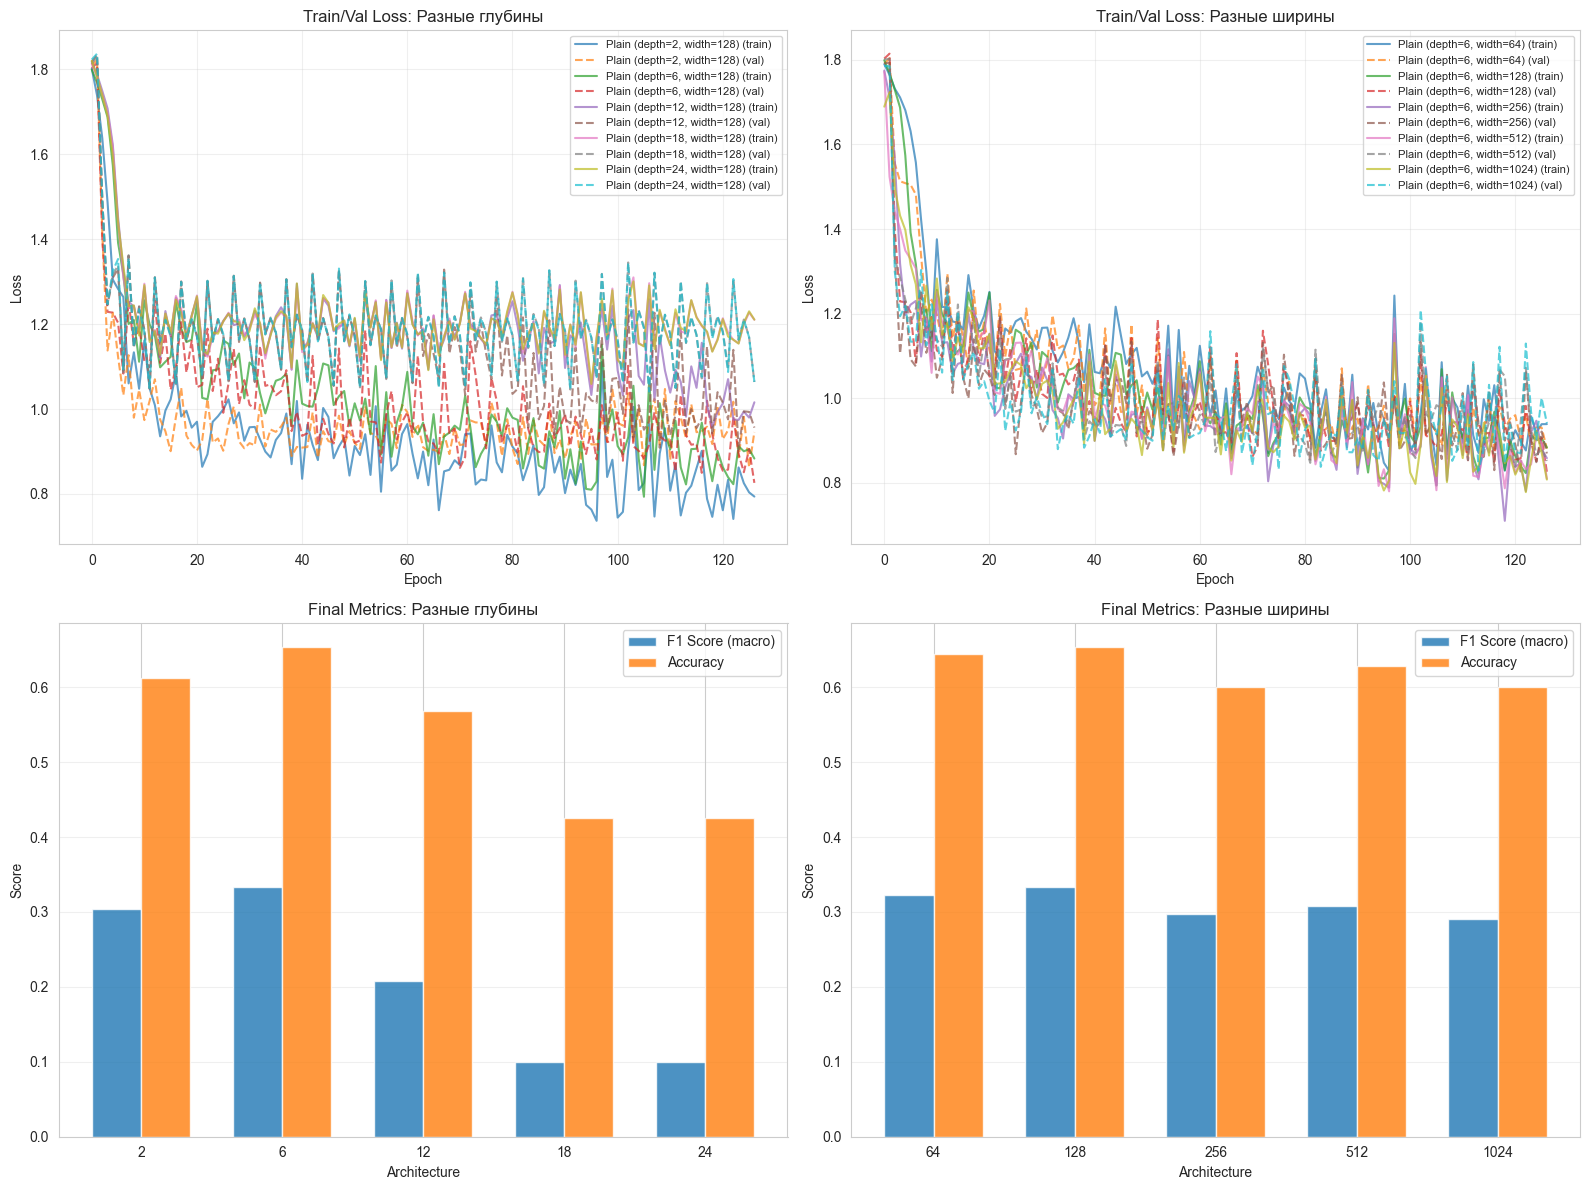


=== Выводы для Plain MLP ===
Лучший F1 (глубина): Plain (depth=6, width=128) (0.3328)
Лучший Accuracy (глубина): Plain (depth=6, width=128) (0.6531)
Лучший F1 (ширина): Plain (depth=6, width=128) (0.3328)
Лучший Accuracy (ширина): Plain (depth=6, width=128) (0.6531)


In [27]:
# Объединяем результаты
all_plain_results = {**results_depth, **results_width}

def average_train_loss_by_epochs(train_losses, num_epochs):
    """Усредняет train_loss по эпохам."""
    if len(train_losses) == num_epochs:
        return train_losses
    
    # Вычисляем количество шагов на эпоху
    steps_per_epoch = len(train_losses) // num_epochs
    if steps_per_epoch == 0:
        steps_per_epoch = 1
    
    # Усредняем по эпохам
    averaged = []
    for epoch in range(num_epochs):
        start_idx = epoch * steps_per_epoch
        end_idx = (epoch + 1) * steps_per_epoch
        if end_idx > len(train_losses):
            end_idx = len(train_losses)
        if start_idx < len(train_losses):
            epoch_losses = train_losses[start_idx:end_idx]
            averaged.append(np.mean(epoch_losses))
    
    return averaged

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График train/val loss для разных глубин
ax = axes[0, 0]
for name, history in results_depth.items():
    num_epochs = len(history['val_loss'])
    train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
    epochs = range(num_epochs)
    ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
    ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train/Val Loss: Разные глубины')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# График train/val loss для разных ширин
ax = axes[0, 1]
for name, history in results_width.items():
    num_epochs = len(history['val_loss'])
    train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
    epochs = range(num_epochs)
    ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
    ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train/Val Loss: Разные ширины')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Сравнение метрик для разных глубин
ax = axes[1, 0]
names_depth = list(results_depth.keys())
f1_scores_depth = [results_depth[n]['final_f1'] for n in names_depth]
accuracy_scores_depth = [results_depth[n]['final_accuracy'] for n in names_depth]

x = np.arange(len(names_depth))
width = 0.35
ax.bar(x - width/2, f1_scores_depth, width, label='F1 Score (macro)', alpha=0.8)
ax.bar(x + width/2, accuracy_scores_depth, width, label='Accuracy', alpha=0.8)
ax.set_xlabel('Architecture')
ax.set_ylabel('Score')
ax.set_title('Final Metrics: Разные глубины')
ax.set_xticks(x)
ax.set_xticklabels([n.split('depth=')[1].split(',')[0] for n in names_depth], rotation=0)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Сравнение метрик для разных ширин
ax = axes[1, 1]
names_width = list(results_width.keys())
f1_scores_width = [results_width[n]['final_f1'] for n in names_width]
accuracy_scores_width = [results_width[n]['final_accuracy'] for n in names_width]

x = np.arange(len(names_width))
width = 0.35
ax.bar(x - width/2, f1_scores_width, width, label='F1 Score (macro)', alpha=0.8)
ax.bar(x + width/2, accuracy_scores_width, width, label='Accuracy', alpha=0.8)
ax.set_xlabel('Architecture')
ax.set_ylabel('Score')
ax.set_title('Final Metrics: Разные ширины')
ax.set_xticks(x)
ax.set_xticklabels([n.split('width=')[1].split(')')[0] for n in names_width], rotation=0)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Выводы
print("\n=== Выводы для Plain MLP ===")
best_f1_depth = max(results_depth.items(), key=lambda x: x[1]['final_f1'])
best_accuracy_depth = max(results_depth.items(), key=lambda x: x[1]['final_accuracy'])
print(f"Лучший F1 (глубина): {best_f1_depth[0]} ({best_f1_depth[1]['final_f1']:.4f})")
print(f"Лучший Accuracy (глубина): {best_accuracy_depth[0]} ({best_accuracy_depth[1]['final_accuracy']:.4f})")

best_f1_width = max(results_width.items(), key=lambda x: x[1]['final_f1'])
best_accuracy_width = max(results_width.items(), key=lambda x: x[1]['final_accuracy'])
print(f"Лучший F1 (ширина): {best_f1_width[0]} ({best_f1_width[1]['final_f1']:.4f})")
print(f"Лучший Accuracy (ширина): {best_accuracy_width[0]} ({best_accuracy_width[1]['final_accuracy']:.4f})")


## 5. Добавление нормализации

Теперь добавим нормализацию. Реализуем блоки с различными типами нормализации через наследование от базового класса.


In [28]:
class BatchNormMLPBlock(BaseMLPBlock):
    """
    MLP блок с BatchNorm нормализацией (pre-norm).
    """
    def __init__(self, dim, hidden_dim=None, activation='relu', dropout=0.0):
        super().__init__(dim, hidden_dim, activation, dropout)
        self.norm = nn.BatchNorm1d(self.dim)
    
    def forward(self, x):
        x = self.norm(x)
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x


class LayerNormMLPBlock(BaseMLPBlock):
    """
    MLP блок с LayerNorm нормализацией (pre-norm).
    """
    def __init__(self, dim, hidden_dim=None, activation='relu', dropout=0.0):
        super().__init__(dim, hidden_dim, activation, dropout)
        self.norm = nn.LayerNorm(self.dim)
    
    def forward(self, x):
        x = self.norm(x)
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x


class GroupNormMLPBlock(BaseMLPBlock):
    """
    MLP блок с GroupNorm нормализацией (pre-norm).
    """
    def __init__(self, dim, hidden_dim=None, activation='relu', dropout=0.0, num_groups=8):
        super().__init__(dim, hidden_dim, activation, dropout)
        # GroupNorm с разумным количеством групп
        num_groups = min(num_groups, dim // 4) if dim >= 4 else 1
        self.norm = nn.GroupNorm(num_groups, self.dim)
    
    def forward(self, x):
        x = self.norm(x)
        x = self.linear1(x)
        x = self.activation(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x


# Классы для глубоких сетей с нормализацией
class BatchNormDeepMLP(BaseDeepMLP):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_blocks=4, block_kwargs=None):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            BatchNormMLPBlock(dim=hidden_dim, hidden_dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


class LayerNormDeepMLP(BaseDeepMLP):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_blocks=4, block_kwargs=None):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            LayerNormMLPBlock(dim=hidden_dim, hidden_dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


class GroupNormDeepMLP(BaseDeepMLP):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_blocks=4, block_kwargs=None):
        super().__init__(input_dim, output_dim, hidden_dim, num_blocks, block_kwargs)
        block_kwargs = block_kwargs or {}
        self.blocks = nn.ModuleList([
            GroupNormMLPBlock(dim=hidden_dim, hidden_dim=hidden_dim, **block_kwargs)
            for _ in range(num_blocks)
        ])


# Проверка корректности
print("=== Проверка блоков с нормализацией ===")
batch_size = 32
dim = 64

block_bn = BatchNormMLPBlock(dim=dim, hidden_dim=dim)
block_ln = LayerNormMLPBlock(dim=dim, hidden_dim=dim)
block_gn = GroupNormMLPBlock(dim=dim, hidden_dim=dim)

x = torch.randn(batch_size, dim)

out_bn = block_bn(x)
out_ln = block_ln(x)
out_gn = block_gn(x)

assert out_bn.shape == x.shape
assert out_ln.shape == x.shape
assert out_gn.shape == x.shape

print(f"✓ BatchNorm: {x.shape} -> {out_bn.shape}")
print(f"✓ LayerNorm: {x.shape} -> {out_ln.shape}")
print(f"✓ GroupNorm: {x.shape} -> {out_gn.shape}")
print("✓ Все блоки с нормализацией работают корректно!")


=== Проверка блоков с нормализацией ===
✓ BatchNorm: torch.Size([32, 64]) -> torch.Size([32, 64])
✓ LayerNorm: torch.Size([32, 64]) -> torch.Size([32, 64])
✓ GroupNorm: torch.Size([32, 64]) -> torch.Size([32, 64])
✓ Все блоки с нормализацией работают корректно!


## 6. Эксперимент 2: MLP с нормализацией - разные глубины и ширины

Изучим влияние нормализации на обучение при разных глубинах и ширинах.


In [29]:
# Эксперимент с разными типами нормализации и глубинами
depths = [6, 18]
hidden_dim = 128
results_norm_depth = {}

norm_classes = {
    'BatchNorm': BatchNormDeepMLP,
    'LayerNorm': LayerNormDeepMLP,
    'GroupNorm': GroupNormDeepMLP
}

for norm_name, norm_class in norm_classes.items():
    for num_blocks in depths:
        model = norm_class(
            input_dim=data_module.input_dim,
            output_dim=data_module.n_classes,
            hidden_dim=hidden_dim,
            num_blocks=num_blocks,
            block_kwargs={'dropout': 0.1}
        )
        
        name = f"{norm_name} (depth={num_blocks}, width={hidden_dim})"
        history = train_model(model, name, max_epochs=25)
        results_norm_depth[name] = history


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение BatchNorm (depth=6, width=128) ===
Epoch 0: accuracy=0.0156, f1_macro=0.0062
Epoch 0: accuracy=0.2902, f1_macro=0.0898
Epoch 1: accuracy=0.3828, f1_macro=0.1398
Epoch 2: accuracy=0.4366, f1_macro=0.1824
Epoch 3: accuracy=0.4631, f1_macro=0.1992
Epoch 4: accuracy=0.4890, f1_macro=0.2218
Epoch 5: accuracy=0.5039, f1_macro=0.2311
Epoch 6: accuracy=0.5186, f1_macro=0.2466
Epoch 7: accuracy=0.5290, f1_macro=0.2464
Epoch 8: accuracy=0.5372, f1_macro=0.2529
Epoch 9: accuracy=0.5439, f1_macro=0.2574
Epoch 10: accuracy=0.5502, f1_macro=0.2616
Epoch 11: accuracy=0.5570, f1_macro=0.2648
Epoch 12: accuracy=0.5620, f1_macro=0.2672
Epoch 13: accuracy=0.5671, f1_macro=0.2709
Epoch 14: accuracy=0.5698, f1_macro=0.2738
Epoch 15: accuracy=0.5726, f1_macro=0.2769
Epoch 16: accuracy=0.5733, f1_macro=0.2770
Epoch 17: accuracy=0.5752, f1_macro=0.2788
Epoch 18: accuracy=0.5775, f1_macro=0.2815
Epoch 19: accuracy=0.5781, f1_macro=0.2817
Epoch 20: accuracy=0.5805, f1_macro=0.2837
Epoch 21: accura

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5859, f1_macro=0.2886


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5969, F1 (macro): 0.2970

=== Обучение BatchNorm (depth=18, width=128) ===
Epoch 0: accuracy=0.0469, f1_macro=0.0179
Epoch 0: accuracy=0.3170, f1_macro=0.1039
Epoch 1: accuracy=0.3516, f1_macro=0.1514
Epoch 2: accuracy=0.3658, f1_macro=0.1520
Epoch 3: accuracy=0.3743, f1_macro=0.1532
Epoch 4: accuracy=0.3837, f1_macro=0.1555
Epoch 5: accuracy=0.3926, f1_macro=0.1573
Epoch 6: accuracy=0.3957, f1_macro=0.1565
Epoch 7: accuracy=0.3984, f1_macro=0.1575
Epoch 8: accuracy=0.4013, f1_macro=0.1573
Epoch 9: accuracy=0.4056, f1_macro=0.1579
Epoch 10: accuracy=0.4057, f1_macro=0.1578
Epoch 11: accuracy=0.4093, f1_macro=0.1587
Epoch 12: accuracy=0.4135, f1_macro=0.1593
Epoch 13: accuracy=0.4173, f1_macro=0.1600
Epoch 14: accuracy=0.4211, f1_macro=0.1610
Epoch 15: accuracy=0.4244, f1_macro=0.1616
Epoch 16: accuracy=0.4247, f1_macro=0.1618
Epoch 17: accuracy=0.4226, f1_macro=0.1608
Epoch 18: accuracy=0.4249, f1_macro=0.1611
Epoch 19: accuracy=0.4266, f1_macro=0.1611
Epoch 20: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4342, f1_macro=0.1645


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.4375, F1 (macro): 0.1440

=== Обучение LayerNorm (depth=6, width=128) ===
Epoch 0: accuracy=0.0312, f1_macro=0.0392
Epoch 0: accuracy=0.3460, f1_macro=0.1429
Epoch 1: accuracy=0.4414, f1_macro=0.1847
Epoch 2: accuracy=0.4733, f1_macro=0.1917
Epoch 3: accuracy=0.4787, f1_macro=0.1886
Epoch 4: accuracy=0.4792, f1_macro=0.1860
Epoch 5: accuracy=0.4800, f1_macro=0.1824
Epoch 6: accuracy=0.4818, f1_macro=0.1805
Epoch 7: accuracy=0.4862, f1_macro=0.1808
Epoch 8: accuracy=0.4907, f1_macro=0.1813
Epoch 9: accuracy=0.4964, f1_macro=0.1826
Epoch 10: accuracy=0.5025, f1_macro=0.1847
Epoch 11: accuracy=0.5076, f1_macro=0.1865
Epoch 12: accuracy=0.5098, f1_macro=0.1871
Epoch 13: accuracy=0.5098, f1_macro=0.1865
Epoch 14: accuracy=0.5101, f1_macro=0.1861
Epoch 15: accuracy=0.5118, f1_macro=0.1864
Epoch 16: accuracy=0.5149, f1_macro=0.1874
Epoch 17: accuracy=0.5175, f1_macro=0.1881
Epoch 18: accuracy=0.5198, f1_macro=0.1889
Epoch 19: accuracy=0.5219, f1_macro=0.1895
Epoch 20: accuracy=0.5

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5306, f1_macro=0.1934


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5844, F1 (macro): 0.2140

=== Обучение LayerNorm (depth=18, width=128) ===
Epoch 0: accuracy=0.0156, f1_macro=0.0121
Epoch 0: accuracy=0.2902, f1_macro=0.0949
Epoch 1: accuracy=0.3464, f1_macro=0.1472
Epoch 2: accuracy=0.3621, f1_macro=0.1452
Epoch 3: accuracy=0.3707, f1_macro=0.1403
Epoch 4: accuracy=0.3808, f1_macro=0.1497
Epoch 5: accuracy=0.3877, f1_macro=0.1519
Epoch 6: accuracy=0.3927, f1_macro=0.1516
Epoch 7: accuracy=0.3936, f1_macro=0.1521
Epoch 8: accuracy=0.3969, f1_macro=0.1519
Epoch 9: accuracy=0.3996, f1_macro=0.1511
Epoch 10: accuracy=0.3997, f1_macro=0.1520
Epoch 11: accuracy=0.3997, f1_macro=0.1521
Epoch 12: accuracy=0.4016, f1_macro=0.1520
Epoch 13: accuracy=0.4032, f1_macro=0.1515
Epoch 14: accuracy=0.4046, f1_macro=0.1509
Epoch 15: accuracy=0.4059, f1_macro=0.1501
Epoch 16: accuracy=0.4055, f1_macro=0.1511
Epoch 17: accuracy=0.4052, f1_macro=0.1516
Epoch 18: accuracy=0.4062, f1_macro=0.1512
Epoch 19: accuracy=0.4072, f1_macro=0.1507
Epoch 20: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4097, f1_macro=0.1493


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение GroupNorm (depth=6, width=128) ===
Epoch 0: accuracy=0.0312, f1_macro=0.0910
Epoch 0: accuracy=0.3996, f1_macro=0.2172
Epoch 1: accuracy=0.4492, f1_macro=0.2126
Epoch 2: accuracy=0.4853, f1_macro=0.2151
Epoch 3: accuracy=0.5036, f1_macro=0.2461
Epoch 4: accuracy=0.5150, f1_macro=0.2413
Epoch 5: accuracy=0.5273, f1_macro=0.2395
Epoch 6: accuracy=0.5380, f1_macro=0.2551
Epoch 7: accuracy=0.5450, f1_macro=0.2525
Epoch 8: accuracy=0.5522, f1_macro=0.2605
Epoch 9: accuracy=0.5565, f1_macro=0.2579
Epoch 10: accuracy=0.5611, f1_macro=0.2560
Epoch 11: accuracy=0.5648, f1_macro=0.2542
Epoch 12: accuracy=0.5662, f1_macro=0.2522
Epoch 13: accuracy=0.5688, f1_macro=0.2506
Epoch 14: accuracy=0.5702, f1_macro=0.2488
Epoch 15: accuracy=0.5730, f1_macro=0.2554
Epoch 16: accuracy=0.5740, f1_macro=0.2538
Epoch 17: accuracy=0.5759, f1_macro=0.2527
Epoch 18: accuracy=0.5778, f1_macro=0.2517
Epoch 19: accuracy=0.5781, f1_macro=0.2502
Epoch 20: accuracy=0.5

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5859, f1_macro=0.2622


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6094, F1 (macro): 0.2969

=== Обучение GroupNorm (depth=18, width=128) ===
Epoch 0: accuracy=0.0156, f1_macro=0.0072
Epoch 0: accuracy=0.2902, f1_macro=0.0911
Epoch 1: accuracy=0.3464, f1_macro=0.1443
Epoch 2: accuracy=0.3621, f1_macro=0.1428
Epoch 3: accuracy=0.3707, f1_macro=0.1384
Epoch 4: accuracy=0.3808, f1_macro=0.1482
Epoch 5: accuracy=0.3877, f1_macro=0.1506
Epoch 6: accuracy=0.3927, f1_macro=0.1505
Epoch 7: accuracy=0.3936, f1_macro=0.1511
Epoch 8: accuracy=0.3969, f1_macro=0.1510
Epoch 9: accuracy=0.3996, f1_macro=0.1503
Epoch 10: accuracy=0.3997, f1_macro=0.1513
Epoch 11: accuracy=0.3997, f1_macro=0.1514
Epoch 12: accuracy=0.4016, f1_macro=0.1514
Epoch 13: accuracy=0.4032, f1_macro=0.1510
Epoch 14: accuracy=0.4046, f1_macro=0.1504
Epoch 15: accuracy=0.4059, f1_macro=0.1497
Epoch 16: accuracy=0.4055, f1_macro=0.1507
Epoch 17: accuracy=0.4052, f1_macro=0.1513
Epoch 18: accuracy=0.4062, f1_macro=0.1509
Epoch 19: accuracy=0.4072, f1_macro=0.1504
Epoch 20: accuracy=0.

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.4087, f1_macro=0.1504
Accuracy: 0.4250, F1 (macro): 0.0994


### 6.2. Эксперимент с разными типами нормализации и ширинами


In [30]:
# Эксперимент с разными типами нормализации и ширинами
widths = [128, 512]
num_blocks = 6
results_norm_width = {}

for norm_name, norm_class in norm_classes.items():
    for hidden_dim in widths:
        model = norm_class(
            input_dim=data_module.input_dim,
            output_dim=data_module.n_classes,
            hidden_dim=hidden_dim,
            num_blocks=num_blocks,
            block_kwargs={'dropout': 0.1}
        )
        
        name = f"{norm_name} (depth={num_blocks}, width={hidden_dim})"
        history = train_model(model, name, max_epochs=25)
        results_norm_width[name] = history


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



=== Обучение BatchNorm (depth=6, width=128) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.2857, f1_macro=0.0848
Epoch 1: accuracy=0.4049, f1_macro=0.1536
Epoch 2: accuracy=0.4485, f1_macro=0.1730
Epoch 3: accuracy=0.4744, f1_macro=0.1823
Epoch 4: accuracy=0.4919, f1_macro=0.1932
Epoch 5: accuracy=0.5063, f1_macro=0.2024
Epoch 6: accuracy=0.5207, f1_macro=0.2262
Epoch 7: accuracy=0.5298, f1_macro=0.2261
Epoch 8: accuracy=0.5396, f1_macro=0.2403
Epoch 9: accuracy=0.5448, f1_macro=0.2395
Epoch 10: accuracy=0.5485, f1_macro=0.2468
Epoch 11: accuracy=0.5544, f1_macro=0.2507
Epoch 12: accuracy=0.5569, f1_macro=0.2490
Epoch 13: accuracy=0.5625, f1_macro=0.2568
Epoch 14: accuracy=0.5651, f1_macro=0.2607
Epoch 15: accuracy=0.5696, f1_macro=0.2649
Epoch 16: accuracy=0.5715, f1_macro=0.2675
Epoch 17: accuracy=0.5752, f1_macro=0.2696
Epoch 18: accuracy=0.5788, f1_macro=0.2721
Epoch 19: accuracy=0.5797, f1_macro=0.2739
Epoch 20: accuracy=0.5821, f1_macro=0.2759
Epoch 21: accura

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5869, f1_macro=0.2802


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5969, F1 (macro): 0.2905

=== Обучение BatchNorm (depth=6, width=512) ===
Epoch 0: accuracy=0.0156, f1_macro=0.0062
Epoch 0: accuracy=0.3571, f1_macro=0.1495
Epoch 1: accuracy=0.4479, f1_macro=0.1844
Epoch 2: accuracy=0.4844, f1_macro=0.1943
Epoch 3: accuracy=0.5021, f1_macro=0.2202
Epoch 4: accuracy=0.5139, f1_macro=0.2335
Epoch 5: accuracy=0.5244, f1_macro=0.2322
Epoch 6: accuracy=0.5300, f1_macro=0.2424
Epoch 7: accuracy=0.5372, f1_macro=0.2409
Epoch 8: accuracy=0.5445, f1_macro=0.2484
Epoch 9: accuracy=0.5475, f1_macro=0.2513
Epoch 10: accuracy=0.5526, f1_macro=0.2545
Epoch 11: accuracy=0.5565, f1_macro=0.2553
Epoch 12: accuracy=0.5597, f1_macro=0.2590
Epoch 13: accuracy=0.5623, f1_macro=0.2607
Epoch 14: accuracy=0.5627, f1_macro=0.2618
Epoch 15: accuracy=0.5661, f1_macro=0.2638
Epoch 16: accuracy=0.5679, f1_macro=0.2638
Epoch 17: accuracy=0.5708, f1_macro=0.2661
Epoch 18: accuracy=0.5730, f1_macro=0.2678
Epoch 19: accuracy=0.5746, f1_macro=0.2700
Epoch 20: accuracy=0.5

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.5844, F1 (macro): 0.3165

=== Обучение LayerNorm (depth=6, width=128) ===
Epoch 0: accuracy=0.0312, f1_macro=0.0392
Epoch 0: accuracy=0.3460, f1_macro=0.1429
Epoch 1: accuracy=0.4414, f1_macro=0.1847
Epoch 2: accuracy=0.4733, f1_macro=0.1917
Epoch 3: accuracy=0.4787, f1_macro=0.1886
Epoch 4: accuracy=0.4792, f1_macro=0.1860
Epoch 5: accuracy=0.4800, f1_macro=0.1824
Epoch 6: accuracy=0.4818, f1_macro=0.1805
Epoch 7: accuracy=0.4862, f1_macro=0.1808
Epoch 8: accuracy=0.4907, f1_macro=0.1813
Epoch 9: accuracy=0.4964, f1_macro=0.1826
Epoch 10: accuracy=0.5025, f1_macro=0.1847
Epoch 11: accuracy=0.5076, f1_macro=0.1865
Epoch 12: accuracy=0.5098, f1_macro=0.1871
Epoch 13: accuracy=0.5098, f1_macro=0.1865
Epoch 14: accuracy=0.5101, f1_macro=0.1861
Epoch 15: accuracy=0.5118, f1_macro=0.1864
Epoch 16: accuracy=0.5149, f1_macro=0.1874
Epoch 17: accuracy=0.5175, f1_macro=0.1881
Epoch 18: accuracy=0.5198, f1_macro=0.1889
Epoch 19: accuracy=0.5219, f1_macro=0.1895
Epoch 20: accuracy=0.5

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5306, f1_macro=0.1934


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Accuracy: 0.5844, F1 (macro): 0.2140

=== Обучение LayerNorm (depth=6, width=512) ===


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.3542, f1_macro=0.0946
Epoch 2: accuracy=0.3676, f1_macro=0.1390
Epoch 3: accuracy=0.3750, f1_macro=0.1444
Epoch 4: accuracy=0.3843, f1_macro=0.1445
Epoch 5: accuracy=0.3906, f1_macro=0.1429
Epoch 6: accuracy=0.3953, f1_macro=0.1408
Epoch 7: accuracy=0.3958, f1_macro=0.1457
Epoch 8: accuracy=0.3989, f1_macro=0.1443
Epoch 9: accuracy=0.4014, f1_macro=0.1428
Epoch 10: accuracy=0.4013, f1_macro=0.1461
Epoch 11: accuracy=0.4012, f1_macro=0.1478
Epoch 12: accuracy=0.4030, f1_macro=0.1472
Epoch 13: accuracy=0.4045, f1_macro=0.1463
Epoch 14: accuracy=0.4058, f1_macro=0.1454
Epoch 15: accuracy=0.4055, f1_macro=0.1472
Epoch 16: accuracy=0.4052, f1_macro=0.1484
Epoch 17: accuracy=0.4049, f1_macro=0.1490
Epoch 18: accuracy=0.4059, f1_macro=0.1487
Epoch 19: accuracy=0.4069, f1_macro=0.1483
Epoch 20: accuracy=0.4077, f1_macro=0.1478
Epoch 21: accuracy=0.4074, f1_macro=0.1486
Epoch 22: accuracy=0.4

`Trainer.fit` stopped: `max_epochs=25` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.4250, F1 (macro): 0.0994

=== Обучение GroupNorm (depth=6, width=128) ===
Epoch 0: accuracy=0.0312, f1_macro=0.0910
Epoch 0: accuracy=0.3996, f1_macro=0.2172
Epoch 1: accuracy=0.4492, f1_macro=0.2126
Epoch 2: accuracy=0.4853, f1_macro=0.2151
Epoch 3: accuracy=0.5036, f1_macro=0.2461
Epoch 4: accuracy=0.5150, f1_macro=0.2413
Epoch 5: accuracy=0.5273, f1_macro=0.2395
Epoch 6: accuracy=0.5380, f1_macro=0.2551
Epoch 7: accuracy=0.5450, f1_macro=0.2525
Epoch 8: accuracy=0.5522, f1_macro=0.2605
Epoch 9: accuracy=0.5565, f1_macro=0.2579
Epoch 10: accuracy=0.5611, f1_macro=0.2560
Epoch 11: accuracy=0.5648, f1_macro=0.2542
Epoch 12: accuracy=0.5662, f1_macro=0.2522
Epoch 13: accuracy=0.5688, f1_macro=0.2506
Epoch 14: accuracy=0.5702, f1_macro=0.2488
Epoch 15: accuracy=0.5730, f1_macro=0.2554
Epoch 16: accuracy=0.5740, f1_macro=0.2538
Epoch 17: accuracy=0.5759, f1_macro=0.2527
Epoch 18: accuracy=0.5778, f1_macro=0.2517
Epoch 19: accuracy=0.5781, f1_macro=0.2502
Epoch 20: accuracy=0.5

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: accuracy=0.5859, f1_macro=0.2622


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Accuracy: 0.6094, F1 (macro): 0.2969

=== Обучение GroupNorm (depth=6, width=512) ===
Epoch 0: accuracy=0.0000, f1_macro=0.0000
Epoch 0: accuracy=0.3036, f1_macro=0.0901
Epoch 1: accuracy=0.4010, f1_macro=0.1536
Epoch 2: accuracy=0.4458, f1_macro=0.1727
Epoch 3: accuracy=0.4588, f1_macro=0.1768
Epoch 4: accuracy=0.4525, f1_macro=0.1708
Epoch 5: accuracy=0.4482, f1_macro=0.1654
Epoch 6: accuracy=0.4451, f1_macro=0.1606
Epoch 7: accuracy=0.4397, f1_macro=0.1624
Epoch 8: accuracy=0.4382, f1_macro=0.1594
Epoch 9: accuracy=0.4369, f1_macro=0.1566
Epoch 10: accuracy=0.4337, f1_macro=0.1584
Epoch 11: accuracy=0.4309, f1_macro=0.1590
Epoch 12: accuracy=0.4305, f1_macro=0.1575
Epoch 13: accuracy=0.4301, f1_macro=0.1561
Epoch 14: accuracy=0.4298, f1_macro=0.1546
Epoch 15: accuracy=0.4295, f1_macro=0.1531
Epoch 16: accuracy=0.4278, f1_macro=0.1545
Epoch 17: accuracy=0.4263, f1_macro=0.1554
Epoch 18: accuracy=0.4262, f1_macro=0.1544
Epoch 19: accuracy=0.4262, f1_macro=0.1534
Epoch 20: accuracy=0.4

`Trainer.fit` stopped: `max_epochs=25` reached.


Accuracy: 0.4250, F1 (macro): 0.0994


### 6.3. Визуализация результатов для MLP с нормализацией


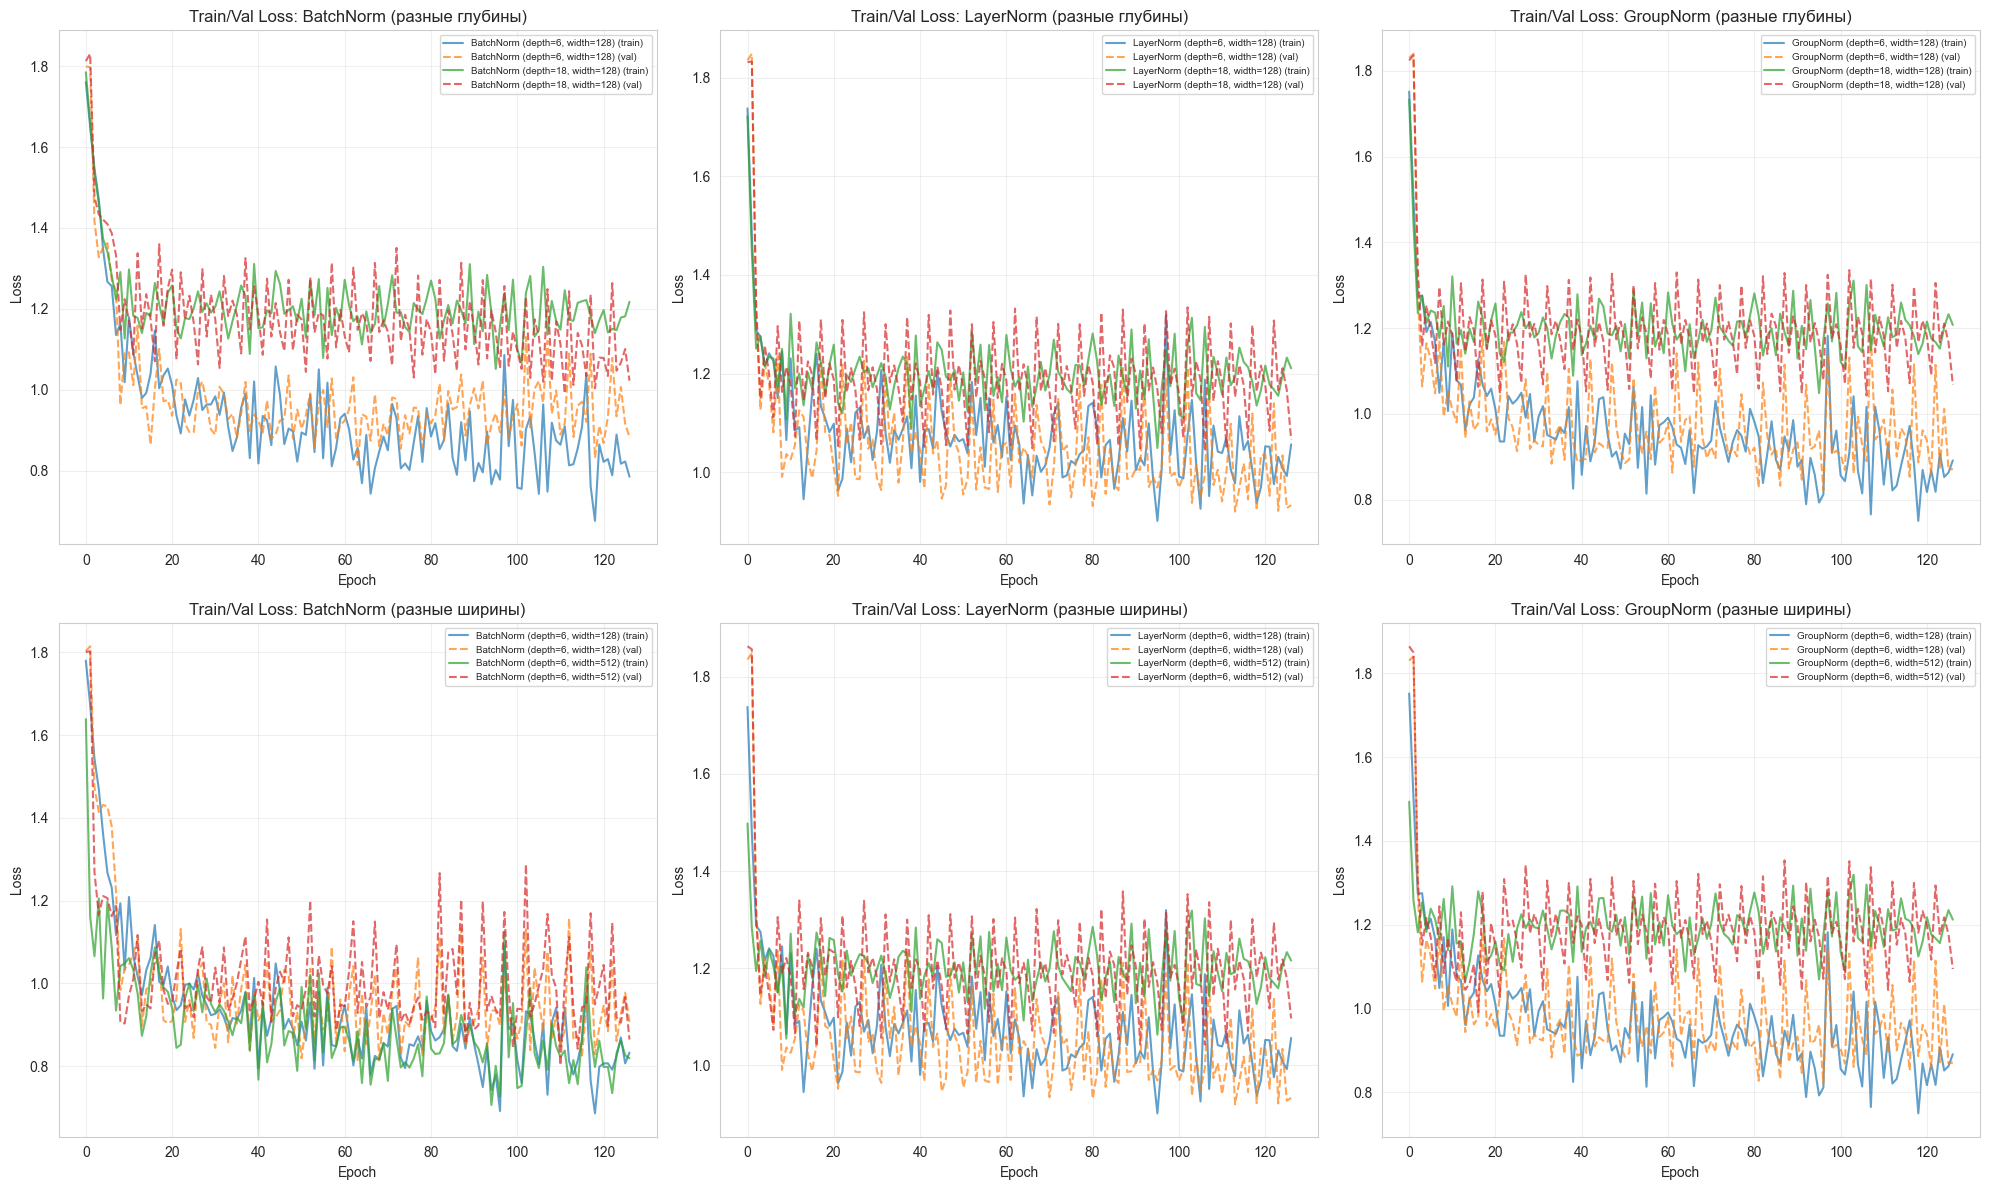

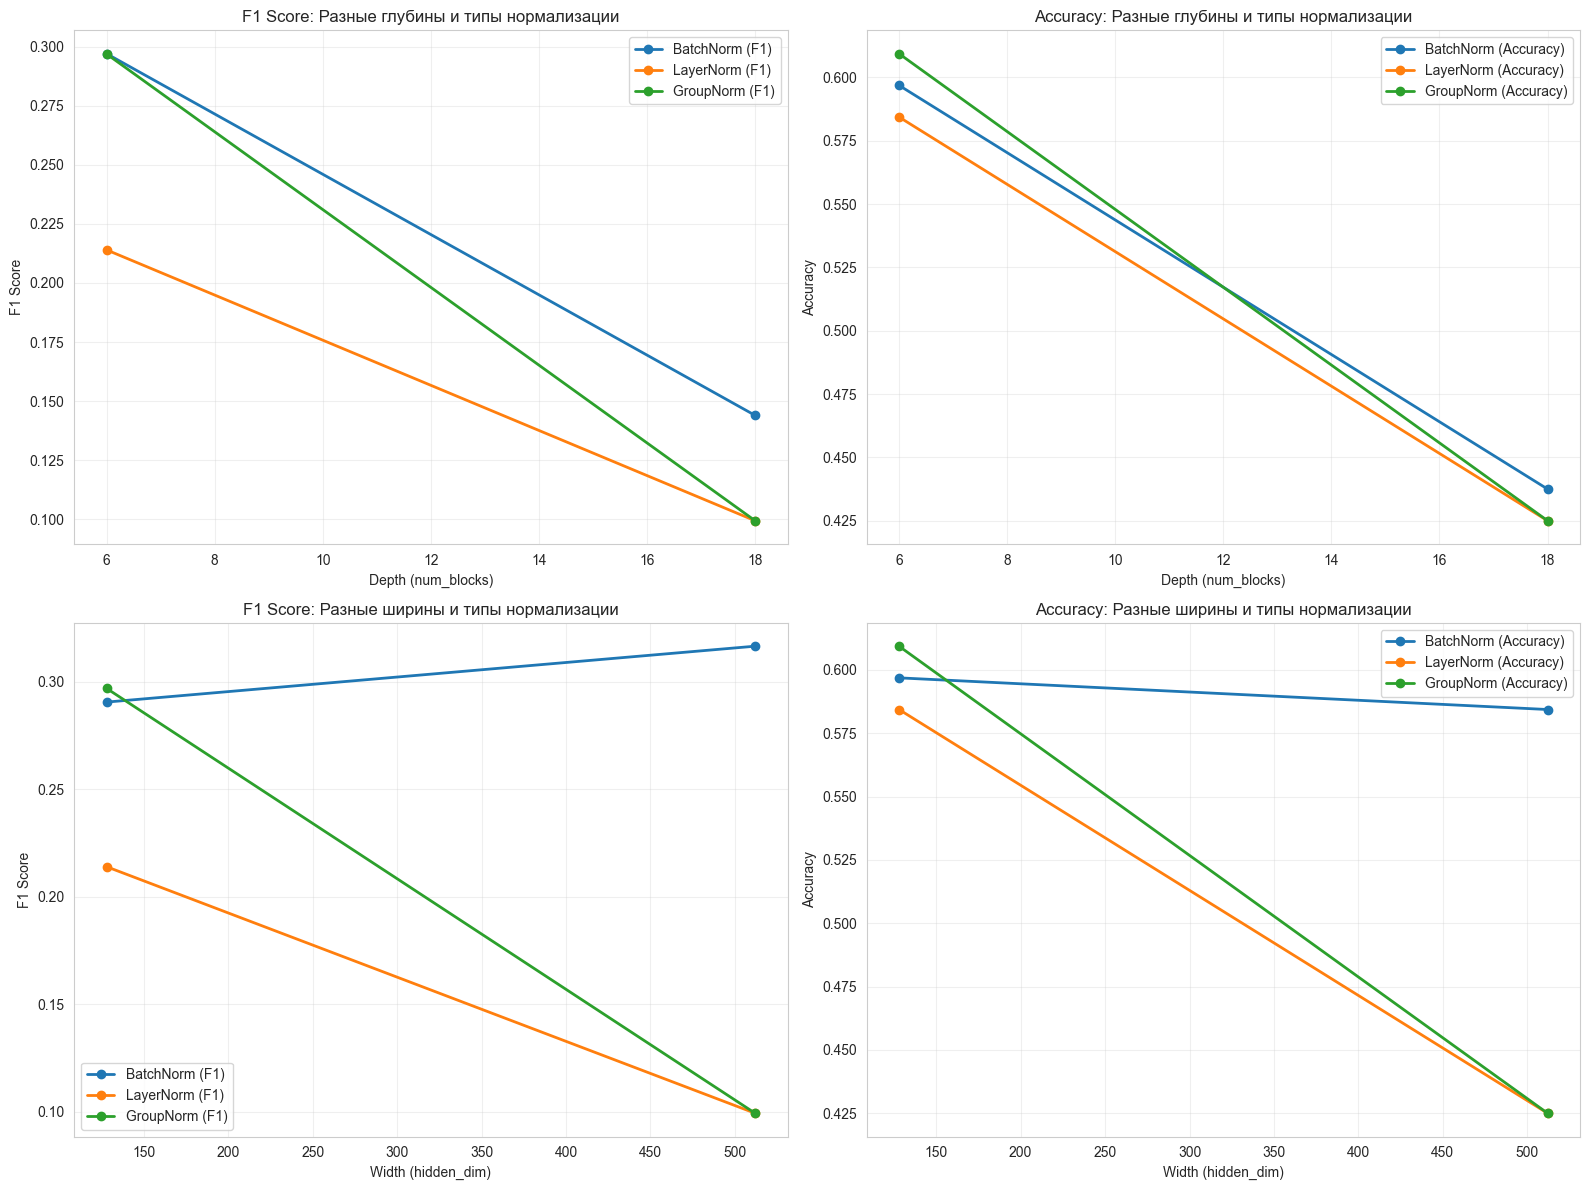

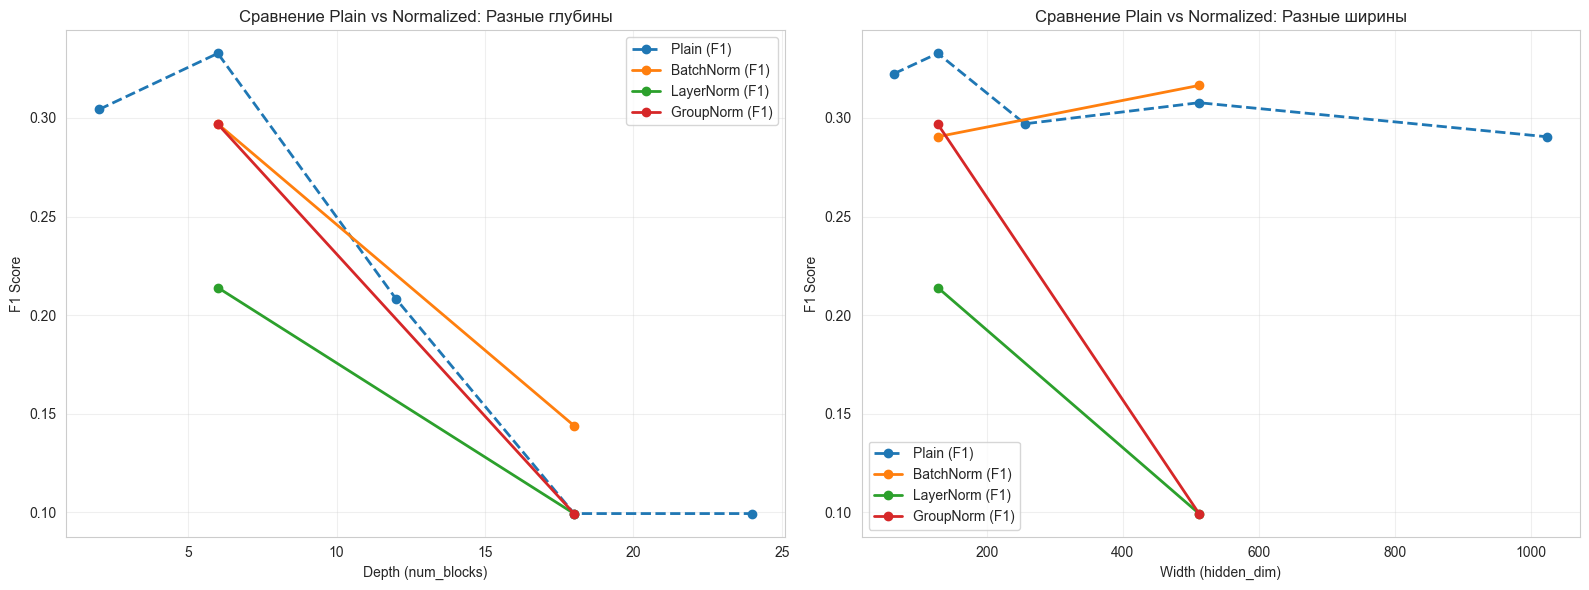


=== Выводы для MLP с нормализацией ===
BatchNorm - Лучший F1: BatchNorm (depth=6, width=128) (0.2970)
BatchNorm - Лучший Accuracy: BatchNorm (depth=6, width=128) (0.5969)
LayerNorm - Лучший F1: LayerNorm (depth=6, width=128) (0.2140)
LayerNorm - Лучший Accuracy: LayerNorm (depth=6, width=128) (0.5844)
GroupNorm - Лучший F1: GroupNorm (depth=6, width=128) (0.2969)
GroupNorm - Лучший Accuracy: GroupNorm (depth=6, width=128) (0.6094)


In [31]:
# Визуализация результатов
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# График train/val loss для разных глубин по типам нормализации
for idx, norm_name in enumerate(['BatchNorm', 'LayerNorm', 'GroupNorm']):
    ax = axes[0, idx]
    for name, history in results_norm_depth.items():
        if norm_name in name:
            num_epochs = len(history['val_loss'])
            train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
            epochs = range(num_epochs)
            ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
            ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Train/Val Loss: {norm_name} (разные глубины)')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

# График train/val loss для разных ширин по типам нормализации
for idx, norm_name in enumerate(['BatchNorm', 'LayerNorm', 'GroupNorm']):
    ax = axes[1, idx]
    for name, history in results_norm_width.items():
        if norm_name in name:
            num_epochs = len(history['val_loss'])
            train_loss_avg = average_train_loss_by_epochs(history['train_loss'], num_epochs)
            epochs = range(num_epochs)
            ax.plot(epochs, train_loss_avg, label=f"{name} (train)", linestyle='-', alpha=0.7)
            ax.plot(epochs, history['val_loss'], label=f"{name} (val)", linestyle='--', alpha=0.7)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'Train/Val Loss: {norm_name} (разные ширины)')
    ax.legend(fontsize=7)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сравнение метрик
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Сравнение метрик для разных глубин
ax = axes[0, 0]
for norm_name in ['BatchNorm', 'LayerNorm', 'GroupNorm']:
    names = [n for n in results_norm_depth.keys() if norm_name in n]
    if names:
        # Извлекаем глубины и ширины из ключей
        depths_widths = [(int(n.split('depth=')[1].split(',')[0]), int(n.split('width=')[1].split(')')[0])) for n in names]
        # Группируем по глубине, берем первую ширину для каждой глубины
        depths_dict = {}
        for d, w in depths_widths:
            if d not in depths_dict:
                depths_dict[d] = w
        
        depths = sorted(depths_dict.keys())
        f1_scores = [results_norm_depth[f"{norm_name} (depth={d}, width={depths_dict[d]})"]['final_f1'] for d in depths]
        ax.plot(depths, f1_scores, marker='o', label=f'{norm_name} (F1)', linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score: Разные глубины и типы нормализации')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
for norm_name in ['BatchNorm', 'LayerNorm', 'GroupNorm']:
    names = [n for n in results_norm_depth.keys() if norm_name in n]
    if names:
        # Извлекаем глубины и ширины из ключей
        depths_widths = [(int(n.split('depth=')[1].split(',')[0]), int(n.split('width=')[1].split(')')[0])) for n in names]
        # Группируем по глубине, берем первую ширину для каждой глубины
        depths_dict = {}
        for d, w in depths_widths:
            if d not in depths_dict:
                depths_dict[d] = w
        
        depths = sorted(depths_dict.keys())
        accuracy_scores = [results_norm_depth[f"{norm_name} (depth={d}, width={depths_dict[d]})"]['final_accuracy'] for d in depths]
        ax.plot(depths, accuracy_scores, marker='o', label=f'{norm_name} (Accuracy)', linewidth=2)
ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Разные глубины и типы нормализации')
ax.legend()
ax.grid(True, alpha=0.3)

# Сравнение метрик для разных ширин
ax = axes[1, 0]
for norm_name in ['BatchNorm', 'LayerNorm', 'GroupNorm']:
    names = [n for n in results_norm_width.keys() if norm_name in n]
    widths_list = sorted([int(n.split('width=')[1].split(')')[0]) for n in names])
    f1_scores = [results_norm_width[f"{norm_name} (depth={num_blocks}, width={w})"]['final_f1'] for w in widths_list]
    ax.plot(widths_list, f1_scores, marker='o', label=f'{norm_name} (F1)', linewidth=2)
ax.set_xlabel('Width (hidden_dim)')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score: Разные ширины и типы нормализации')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
for norm_name in ['BatchNorm', 'LayerNorm', 'GroupNorm']:
    names = [n for n in results_norm_width.keys() if norm_name in n]
    widths_list = sorted([int(n.split('width=')[1].split(')')[0]) for n in names])
    accuracy_scores = [results_norm_width[f"{norm_name} (depth={num_blocks}, width={w})"]['final_accuracy'] for w in widths_list]
    ax.plot(widths_list, accuracy_scores, marker='o', label=f'{norm_name} (Accuracy)', linewidth=2)
ax.set_xlabel('Width (hidden_dim)')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy: Разные ширины и типы нормализации')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сравнение Plain vs Normalized
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Сравнение для разных глубин
ax = axes[0]
# Извлекаем ширину из ключей Plain
plain_names = list(results_depth.keys())
if plain_names:
    plain_width = int(plain_names[0].split('width=')[1].split(')')[0])
    depths_plain = sorted([int(n.split('depth=')[1].split(',')[0]) for n in plain_names])
    f1_plain = [results_depth[f"Plain (depth={d}, width={plain_width})"]['final_f1'] for d in depths_plain]
    ax.plot(depths_plain, f1_plain, marker='o', label='Plain (F1)', linewidth=2, linestyle='--')

for norm_name in ['BatchNorm', 'LayerNorm', 'GroupNorm']:
    names = [n for n in results_norm_depth.keys() if norm_name in n]
    if names:
        # Извлекаем глубины и ширины из ключей
        depths_widths = [(int(n.split('depth=')[1].split(',')[0]), int(n.split('width=')[1].split(')')[0])) for n in names]
        # Группируем по глубине, берем первую ширину для каждой глубины
        depths_dict = {}
        for d, w in depths_widths:
            if d not in depths_dict:
                depths_dict[d] = w
        
        depths = sorted(depths_dict.keys())
        f1_scores = [results_norm_depth[f"{norm_name} (depth={d}, width={depths_dict[d]})"]['final_f1'] for d in depths]
        ax.plot(depths, f1_scores, marker='o', label=f'{norm_name} (F1)', linewidth=2)

ax.set_xlabel('Depth (num_blocks)')
ax.set_ylabel('F1 Score')
ax.set_title('Сравнение Plain vs Normalized: Разные глубины')
ax.legend()
ax.grid(True, alpha=0.3)

# Сравнение для разных ширин
ax = axes[1]
# Извлекаем глубину из ключей Plain
width_names = list(results_width.keys())
if width_names:
    width_depth = int(width_names[0].split('depth=')[1].split(',')[0])
    widths_plain = sorted([int(n.split('width=')[1].split(')')[0]) for n in width_names])
    f1_plain = [results_width[f"Plain (depth={width_depth}, width={w})"]['final_f1'] for w in widths_plain]
    ax.plot(widths_plain, f1_plain, marker='o', label='Plain (F1)', linewidth=2, linestyle='--')

for norm_name in ['BatchNorm', 'LayerNorm', 'GroupNorm']:
    names = [n for n in results_norm_width.keys() if norm_name in n]
    if names:
        # Извлекаем глубину из первого ключа
        norm_depth = int(names[0].split('depth=')[1].split(',')[0])
        widths_list = sorted([int(n.split('width=')[1].split(')')[0]) for n in names])
        f1_scores = [results_norm_width[f"{norm_name} (depth={norm_depth}, width={w})"]['final_f1'] for w in widths_list]
        ax.plot(widths_list, f1_scores, marker='o', label=f'{norm_name} (F1)', linewidth=2)

ax.set_xlabel('Width (hidden_dim)')
ax.set_ylabel('F1 Score')
ax.set_title('Сравнение Plain vs Normalized: Разные ширины')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводы
print("\n=== Выводы для MLP с нормализацией ===")
for norm_name in ['BatchNorm', 'LayerNorm', 'GroupNorm']:
    names = [n for n in results_norm_depth.keys() if norm_name in n]
    if names:
        best_f1 = max([(n, results_norm_depth[n]['final_f1']) for n in names], key=lambda x: x[1])
        best_accuracy = max([(n, results_norm_depth[n]['final_accuracy']) for n in names], key=lambda x: x[1])
        print(f"{norm_name} - Лучший F1: {best_f1[0]} ({best_f1[1]:.4f})")
        print(f"{norm_name} - Лучший Accuracy: {best_accuracy[0]} ({best_accuracy[1]:.4f})")
